In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ensure plots display correctly in Jupyter notebooks
%matplotlib inline


In [2]:
# Get the current date
current_date = datetime.today().strftime('%Y-%m-%d')

# Fetch stock data from Yahoo Finance
ticker = 'RPOWER.NS'
start_date = '2023-08-29'
data = yf.download(ticker, start=start_date, end=current_date, progress=False)
data.reset_index(inplace=True)

# Ensure 'Date' is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

print("Stock data fetched successfully")
print(data.head())


Stock data fetched successfully
        Date       Open   High    Low      Close  Adj Close     Volume
0 2023-08-29  17.650000  18.65  17.60  18.250000  18.250000  195394729
1 2023-08-30  18.500000  20.60  18.25  20.200001  20.200001  569141634
2 2023-08-31  20.400000  20.65  18.90  19.150000  19.150000  264116104
3 2023-09-01  19.299999  19.90  18.90  19.000000  19.000000  134930310
4 2023-09-04  19.299999  20.15  19.00  19.549999  19.549999  143886986


In [4]:
def calculate_support_resistance(data, window=20):
    data['Support'] = data['Low'].rolling(window=window).min()
    data['Resistance'] = data['High'].rolling(window=window).max()
    return data

data = calculate_support_resistance(data)


In [10]:
def calculate_sma(data, window=10):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    return data

def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

data = calculate_sma(data)
data = calculate_rsi(data)


In [11]:
def forecast_next_7_days(data):
    forecasted_prices = []
    last_row = data.iloc[-1].copy()

    for _ in range(7):
        if last_row['RSI'] > 70:
            forecasted_price = last_row['Close'] * 0.98
        elif last_row['RSI'] < 30:
            forecasted_price = last_row['Close'] * 1.02
        else:
            forecasted_price = last_row['Close'] * (1 + np.random.normal(0, 0.01))

        forecasted_prices.append(forecasted_price)
        last_row['Close'] = forecasted_price
        last_row['RSI'] = calculate_rsi(pd.concat([data['Close'], pd.Series(forecasted_prices)]).to_frame('Close')).iloc[-1]['RSI']

    forecast_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=7)
    forecast_df = pd.DataFrame({'Close': forecasted_prices}, index=forecast_dates)

    return forecast_df

forecast_df = forecast_next_7_days(data)


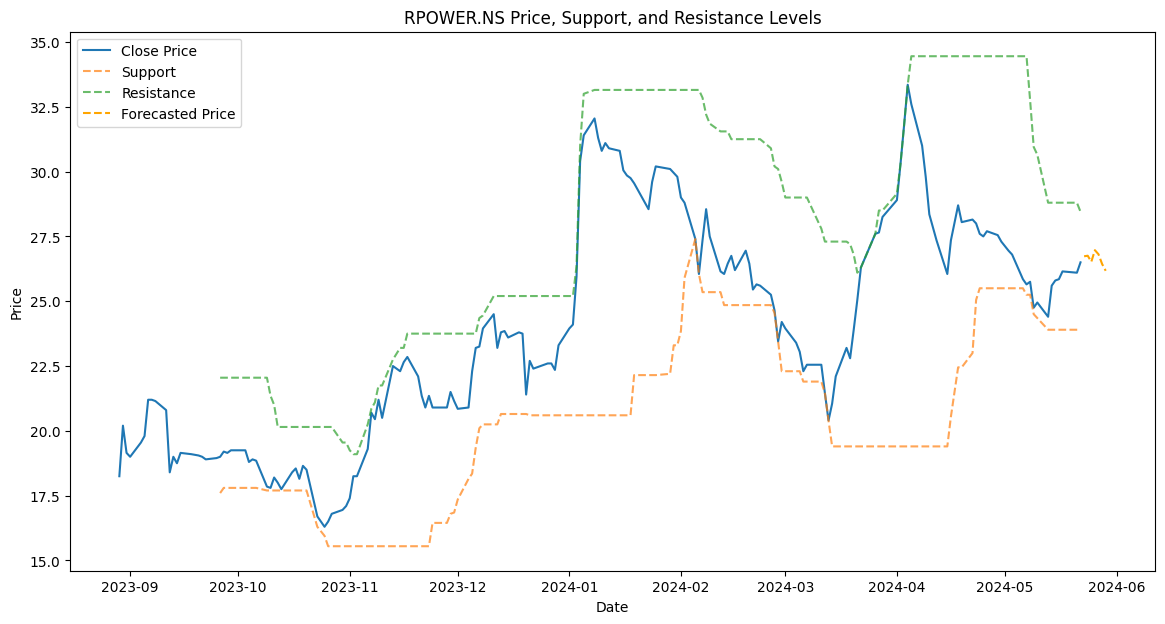

In [12]:
def plot_results(data, forecast_df, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price')
    plt.plot(data['Date'], data['Support'], label='Support', linestyle='--', alpha=0.7)
    plt.plot(data['Date'], data['Resistance'], label='Resistance', linestyle='--', alpha=0.7)
    plt.plot(forecast_df.index, forecast_df['Close'], label='Forecasted Price', linestyle='--', color='orange')
    plt.title(f'{ticker} Price, Support, and Resistance Levels')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_results(data, forecast_df, ticker)


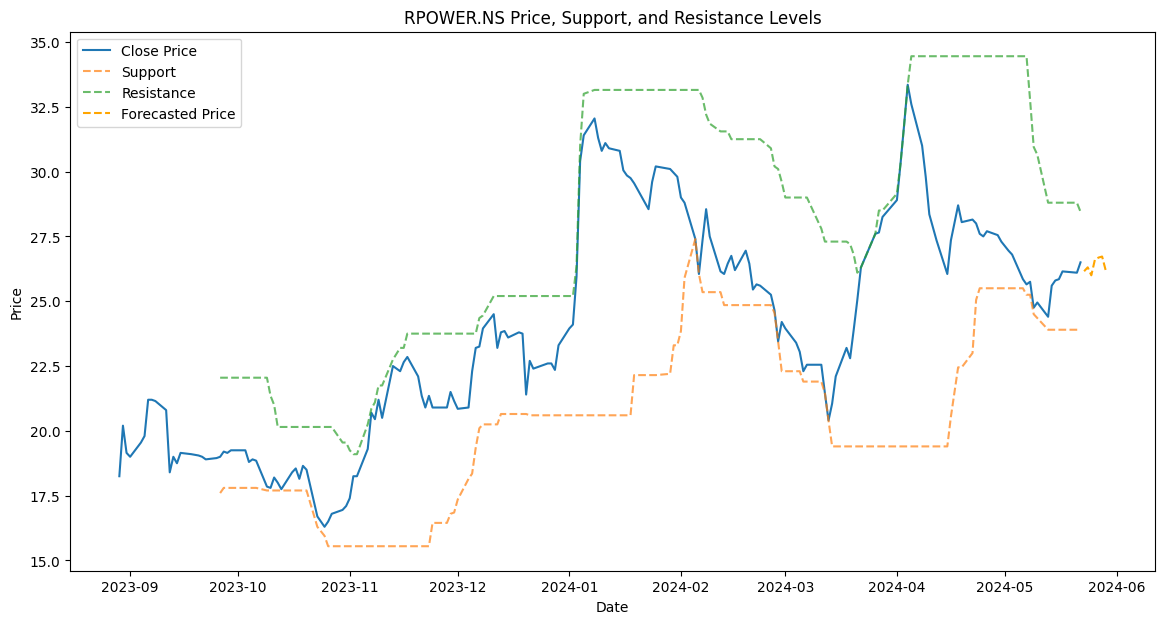

In [13]:
def main(ticker='RPOWER.NS', start='2023-08-29', end=str(datetime.now().date())):
    # Fetch data
    data = yf.download(ticker, start=start, end=end, progress=False)
    data.reset_index(inplace=True)

    # Ensure 'Date' is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Calculate support and resistance
    data = calculate_support_resistance(data)

    # Calculate SMA and RSI
    data = calculate_sma(data)
    data = calculate_rsi(data)

    # Forecast next 7 days
    forecast_df = forecast_next_7_days(data)

    # Plot the results
    plot_results(data, forecast_df, ticker)

    return data, forecast_df

# Run the main function
historical_data, forecast_data = main()


In [14]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [15]:
import joblib

# Save the model using joblib
joblib.dump((historical_data, forecast_data), 'stock_forecast_model.pkl')

print("Model saved successfully")

Model saved successfully
